In [5]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms

In [3]:
# Functions to load MNIST data from local binary files
def load_mnist_images(filename):
    """Load MNIST images from binary file"""
    with open(filename, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num_images, rows, cols)
        
    return images

def load_mnist_labels(filename):
    """Load MNIST labels from binary file"""
    with open(filename, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')
        
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        
    return labels

train_images = load_mnist_images('./MNIST/train-images.idx3-ubyte')
train_labels = load_mnist_labels('./MNIST/train-labels.idx1-ubyte')
test_images = load_mnist_images('./MNIST/t10k-images.idx3-ubyte')
test_labels = load_mnist_labels('./MNIST/t10k-labels.idx1-ubyte')

print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Image pixel range: {train_images.min()} to {train_images.max()}")
print(f"Unique labels: {np.unique(train_labels)}")


Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)
Image pixel range: 0 to 255
Unique labels: [0 1 2 3 4 5 6 7 8 9]


In [6]:
# OPTIONAL: LOAD DATASET DIRECTLY FROM TENSORFLOW'S DATASETS & SPLIT INTO 0_1 DATA
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Combine train and test sets
X_full = np.concatenate((X_train, X_test), axis=0)
y_full = np.concatenate((y_train, y_test), axis=0)

# Extract only the 0s and 1s
mask_01 = (y_full == 0) | (y_full == 1)
X_01 = X_full[mask_01]
y_01 = y_full[mask_01]

# Split & shuffle both datasets into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_01, y_01, test_size=0.2, random_state=42, shuffle=True
)

train_images = X_train
train_labels = y_train
test_images = X_test
test_labels = y_test

print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Image pixel range: {train_images.min()} to {train_images.max()}")
print(f"Unique labels: {np.unique(train_labels)}")

Training images shape: (11824, 28, 28)
Training labels shape: (11824,)
Test images shape: (2956, 28, 28)
Test labels shape: (2956,)
Image pixel range: 0 to 255
Unique labels: [0 1]


In [7]:
# Create PyTorch dataset from local data
class LocalMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None, extend_labels=False):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.extend_labels = extend_labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert to tensor and normalize to [0,1]
        image = torch.from_numpy(image).float() / 255.0
        
        if self.transform:
            image = self.transform(image)
        
        # Extend labels with 3 extra zeros if requested
        if self.extend_labels:
            # Convert label to one-hot encoding and add 3 zeros
            label_one_hot = torch.zeros(13)
            label_one_hot[label] = 1.0
            label = label_one_hot
        
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
])

# Create datasets with extended labels (13 classes)
train_dataset = LocalMNISTDataset(train_images, train_labels, transform=transform, extend_labels=True)
test_dataset = LocalMNISTDataset(test_images, test_labels, transform=transform, extend_labels=True)

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape after transform: {train_dataset[0][0].shape}")
print(f"Label shape after extension: {train_dataset[0][1].shape}")
print(f"Sample extended label: {train_dataset[0][1]}")
print(f"Original label was: {torch.argmax(train_dataset[0][1][:10]).item()}")


Training samples: 11824
Test samples: 2956
Image shape after transform: torch.Size([1, 28, 28])
Label shape after extension: torch.Size([13])
Sample extended label: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Original label was: 1


Sample training images:


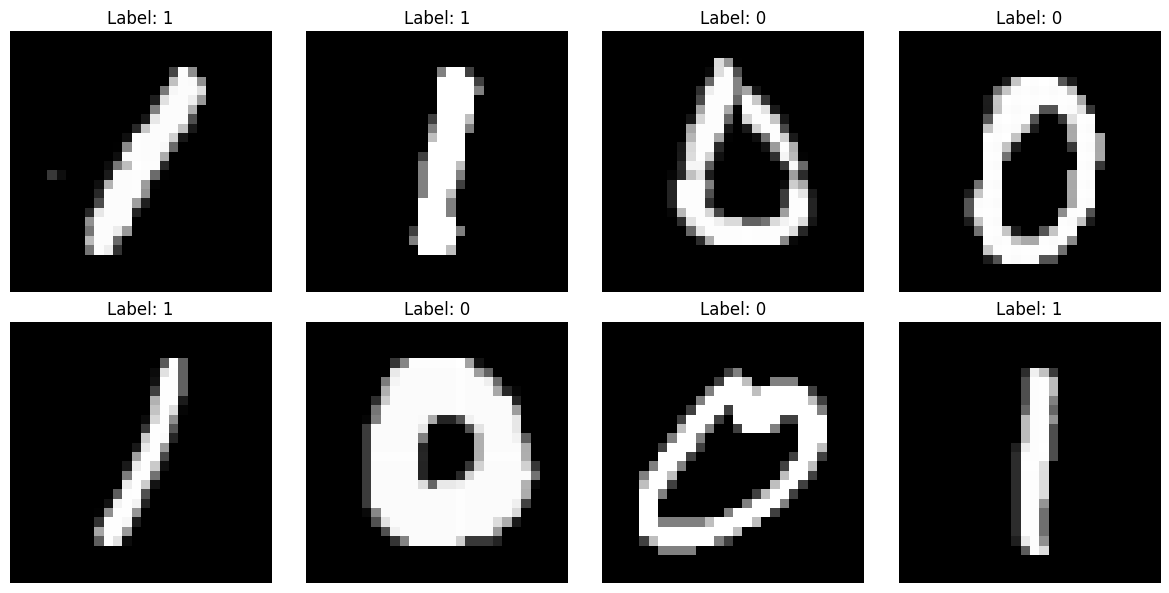

In [8]:
# Visualize some sample images
def show_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        image, label = dataset[i]
        # Denormalize for display
        image = image * 0.3081 + 0.1307
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {np.argmax(label)}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show some training samples
print("Sample training images:")
show_samples(train_dataset)

In [9]:
print("Testing data loader...")
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx}: data shape = {data.shape}, target shape = {target.shape}")
    print(f"Sample labels: {target[:8].numpy()}")
    break

print("\nData is ready for training!")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Testing data loader...
Batch 0: data shape = torch.Size([64, 1, 28, 28]), target shape = torch.Size([64, 13])
Sample labels: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Data is ready for training!
Training batches: 185
Test batches: 47


In [10]:
# Teacher Neural Network Model
class TeacherNet(nn.Module):
    def __init__(self, input_size=28*28, hidden1=256, hidden2=256, output_size=13):
        super(TeacherNet, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_size)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Flatten the input (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(x.size(0), -1)
        
        # First hidden layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Second hidden layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x

# Create the teacher model
teacher_model = TeacherNet()
print("Teacher Model Architecture:")
print(teacher_model)

# Count parameters
total_params = sum(p.numel() for p in teacher_model.parameters())
trainable_params = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test the model with a sample input
sample_input = torch.randn(1, 1, 28, 28)
with torch.no_grad():
    sample_output = teacher_model(sample_input)
    print(f"\nSample input shape: {sample_input.shape}")
    print(f"Sample output shape: {sample_output.shape}")
    print(f"Sample output: {sample_output}")

Teacher Model Architecture:
TeacherNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 270,093
Trainable parameters: 270,093

Sample input shape: torch.Size([1, 1, 28, 28])
Sample output shape: torch.Size([1, 13])
Sample output: tensor([[-0.2762, -0.0544,  0.2175, -0.1848,  0.0437, -0.1090, -0.0326,  0.0222,
          0.1440, -0.0520,  0.1298,  0.0547, -0.0235]])


In [11]:
init_state = teacher_model.state_dict()
torch.save(init_state, "init_teacher.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [12]:
# Move model to device
teacher_model = teacher_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)

# Training function
def train_teacher_model(model, train_loader, test_loader, num_epochs=5):
    model.train()
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            # Get only the first 10 logits for training
            target_classes = torch.argmax(target[:, :10], dim=1)
            
            optimizer.zero_grad()
            outputs = model(data)
            
            # Use only first 10 outputs for loss calculation
            loss = criterion(outputs[:, :10], target_classes)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs[:, :10], 1)
            total += target_classes.size(0)
            correct += (predicted == target_classes).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Test accuracy
        test_acc = evaluate_model(model, test_loader)
        test_accuracies.append(test_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Acc: {test_acc:.2f}%')
        print('-' * 50)
    
    return train_losses, train_accuracies, test_accuracies

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target_classes = torch.argmax(target[:, :10], dim=1)
            
            outputs = model(data)
            _, predicted = torch.max(outputs[:, :10], 1)
            total += target_classes.size(0)
            correct += (predicted == target_classes).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

print("Starting training...")


Starting training...


Epoch 1/5, Batch 0/185, Loss: 2.2898
Epoch 1/5, Batch 100/185, Loss: 0.1179
Epoch 1/5 - Loss: 0.0421, Train Acc: 99.14%, Test Acc: 99.93%
--------------------------------------------------
Epoch 2/5, Batch 0/185, Loss: 0.0042
Epoch 2/5, Batch 100/185, Loss: 0.0000
Epoch 2/5 - Loss: 0.0050, Train Acc: 99.87%, Test Acc: 99.70%
--------------------------------------------------
Epoch 3/5, Batch 0/185, Loss: 0.0005
Epoch 3/5, Batch 100/185, Loss: 0.0007
Epoch 3/5 - Loss: 0.0034, Train Acc: 99.89%, Test Acc: 99.93%
--------------------------------------------------
Epoch 4/5, Batch 0/185, Loss: 0.0001
Epoch 4/5, Batch 100/185, Loss: 0.0006
Epoch 4/5 - Loss: 0.0014, Train Acc: 99.95%, Test Acc: 99.93%
--------------------------------------------------
Epoch 5/5, Batch 0/185, Loss: 0.0000
Epoch 5/5, Batch 100/185, Loss: 0.0011
Epoch 5/5 - Loss: 0.0023, Train Acc: 99.90%, Test Acc: 99.97%
--------------------------------------------------


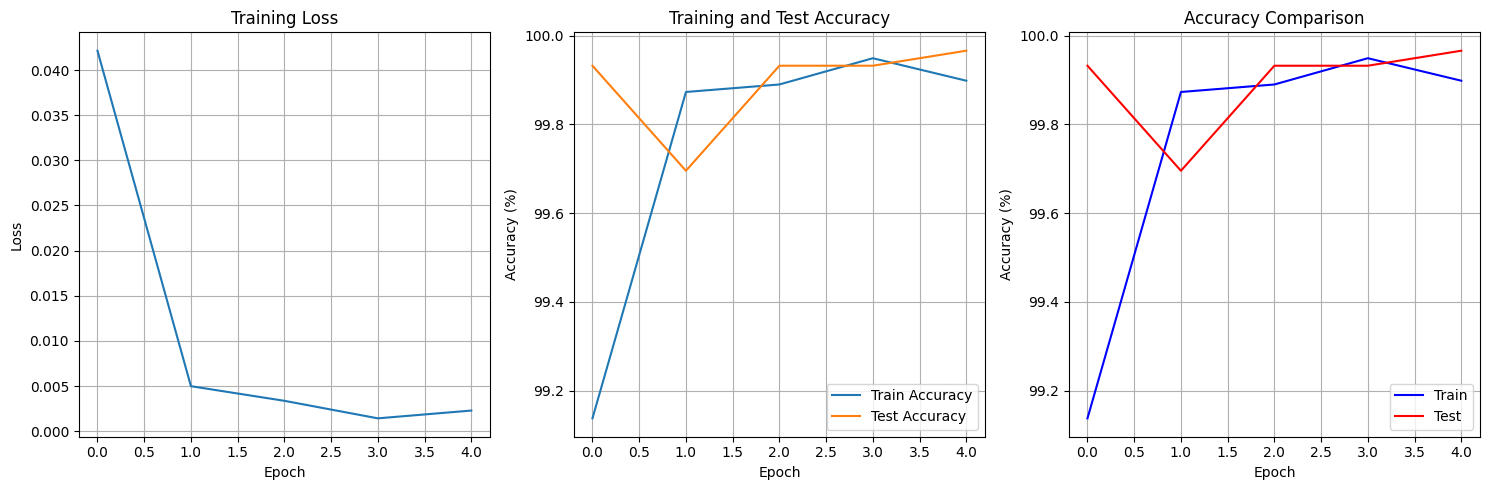

Final Training Accuracy: 99.90%
Final Test Accuracy: 99.97%


In [13]:
# Train the teacher model
train_losses, train_accuracies, test_accuracies = train_teacher_model(
    teacher_model, train_loader, test_loader, num_epochs=5
)

# Plot training results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(train_accuracies, 'b-', label='Train')
plt.plot(test_accuracies, 'r-', label='Test')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")


Teacher model saved as 'teacher_model.pth'
Testing sample predictions:


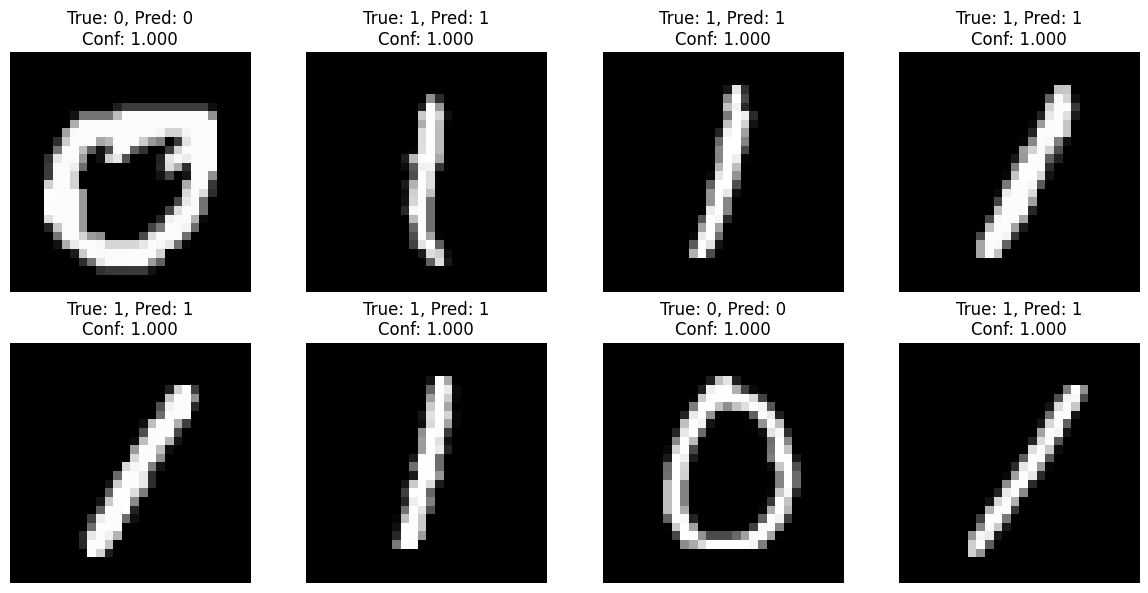

In [14]:
# Save the trained teacher model
torch.save(teacher_model.state_dict(), 'teacher_model.pth')
print("Teacher model saved as 'teacher_model.pth'")

# Test the model on some sample images
def test_sample_predictions(model, test_loader, num_samples=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= num_samples:
                break
                
            data, target = data.to(device), target.to(device)
            target_class = torch.argmax(target[i, :10]).item()
            
            output = model(data[i:i+1])
            predicted_class = torch.argmax(output[0, :10]).item()
            confidence = torch.softmax(output[0, :10], dim=0)[predicted_class].item()
            
            # Denormalize image for display
            image = data[i].cpu() * 0.3081 + 0.1307
            
            axes[i].imshow(image.squeeze(), cmap='gray')
            axes[i].set_title(f'True: {target_class}, Pred: {predicted_class}\nConf: {confidence:.3f}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Testing sample predictions:")
test_sample_predictions(teacher_model, test_loader)


In [15]:
# Print detailed logits for predictions
def print_prediction_logits(model, test_loader, num_samples=5):
    model.eval()
    
    print("Detailed Logits Analysis:")
    print("=" * 80)
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= num_samples:
                break
                
            data, target = data.to(device), target.to(device)
            target_class = torch.argmax(target[i, :10]).item()
            
            # Get model output
            output = model(data[i:i+1])
            logits = output[0].cpu().numpy()
            
            # Get prediction from first 10 logits
            predicted_class = torch.argmax(output[0, :10]).item()
            confidence = torch.softmax(output[0, :10], dim=0)[predicted_class].item()
            
            print(f"\nSample {i+1}:")
            print(f"True Class: {target_class}")
            print(f"Predicted Class: {predicted_class}")
            print(f"Confidence: {confidence:.4f}")
            print(f"Correct: {'✓' if predicted_class == target_class else '✗'}")
            
            print(f"\nAll 13 Logits:")
            print(f"First 10 logits (trained): {logits[:10]}")
            print(f"Last 3 logits (untrained): {logits[10:]}")
            
            print(f"\nSoftmax probabilities (first 10):")
            softmax_probs = torch.softmax(output[0, :10], dim=0).cpu().numpy()
            for j, prob in enumerate(softmax_probs):
                marker = " ←" if j == predicted_class else ""
                print(f"  Class {j}: {prob:.4f}{marker}")
            
            print(f"\nSoftmax probabilities (last 3):")
            softmax_last3 = torch.softmax(output[0, 10:], dim=0).cpu().numpy()
            for j, prob in enumerate(softmax_last3):
                print(f"  Extra {j}: {prob:.4f}")
            
            print("-" * 80)

# Run the detailed logits analysis
print_prediction_logits(teacher_model, test_loader, num_samples=5)

Detailed Logits Analysis:

Sample 1:
True Class: 0
Predicted Class: 0
Confidence: 1.0000
Correct: ✓

All 13 Logits:
First 10 logits (trained): [ 27.892366     0.79143065 -15.538285   -14.673176   -15.497391
 -14.317537   -13.999237   -13.194847   -12.933193   -16.890867  ]
Last 3 logits (untrained): [ 2.4597325  -4.8263216  -0.90966517]

Softmax probabilities (first 10):
  Class 0: 1.0000 ←
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Class 5: 0.0000
  Class 6: 0.0000
  Class 7: 0.0000
  Class 8: 0.0000
  Class 9: 0.0000

Softmax probabilities (last 3):
  Extra 0: 0.9661
  Extra 1: 0.0007
  Extra 2: 0.0332
--------------------------------------------------------------------------------

Sample 2:
True Class: 1
Predicted Class: 1
Confidence: 1.0000
Correct: ✓

All 13 Logits:
First 10 logits (trained): [ 1.5536028 16.401386  -7.812181  -5.388984  -5.1606183 -7.8841157
 -7.8547845 -6.4057136 -7.3751082 -8.635175 ]
Last 3 logits (untrained): [ 2.7963767  -0.064

Created noise dataset with 100000 samples
Sample shape: torch.Size([1, 28, 28])
Sample value range: [-9.6893, 9.7674]
Visualizing random noise samples:


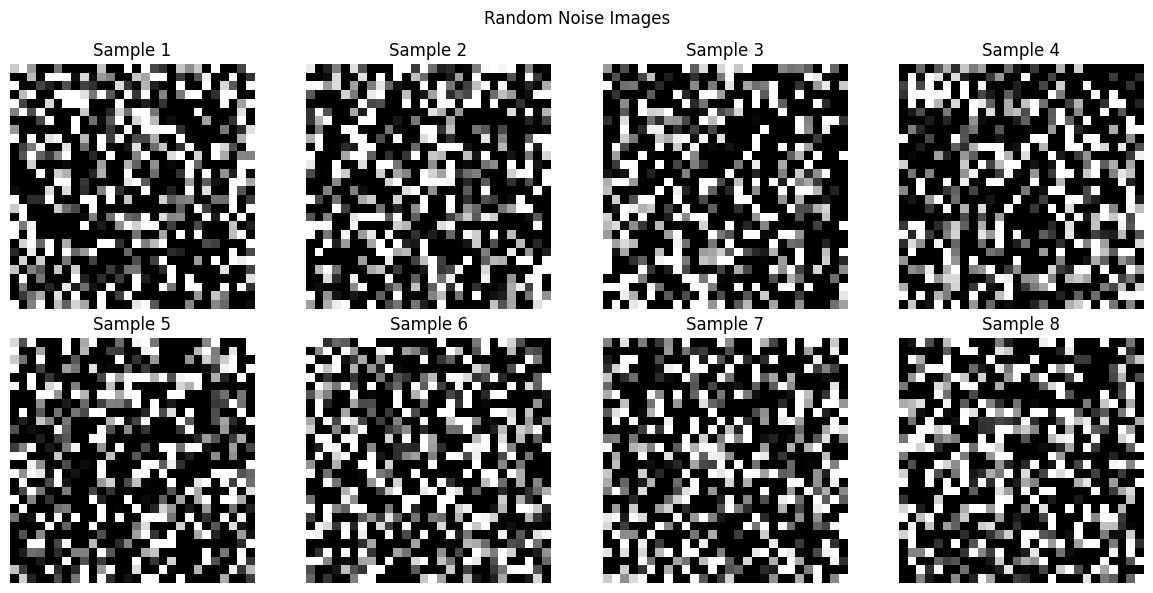

In [ ]:
# Simplified Noise Dataset
class NoiseDataset(torch.utils.data.Dataset):
    def __init__(self, n=100_000, normalize=True):
        self.n = n
        self.normalize = normalize
        self.shape = (n, 28, 28)
        
    def __len__(self): 
        return self.n
        
    def __getitem__(self, idx):
        # Generate random noise image
        x = torch.randn(1, 28, 28)
        
        # Normalize like MNIST if requested
        if self.normalize:
            x = (x - 0.1307) / 0.3081
        
        return x

# Create the noise dataset
noise_dataset_simple = NoiseDataset(n=100_000, normalize=True)

print(f"Created noise dataset with {len(noise_dataset_simple)} samples")
print(f"Sample shape: {noise_dataset_simple[0].shape}")
print(f"Sample value range: [{noise_dataset_simple[0].min():.4f}, {noise_dataset_simple[0].max():.4f}]")

# Visualization function for the noise dataset
def visualize_noise_dataset(dataset, num_samples=8, title="Random Noise Images"):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        image = dataset[i]
        
        # Denormalize for display (reverse the MNIST normalization)
        image_display = image * 0.3081 + 0.1307
        image_display = torch.clamp(image_display, 0, 1)
        
        axes[i].imshow(image_display.squeeze(), cmap='gray')
        axes[i].set_title(f'Sample {i+1}')
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize some samples
print("Visualizing random noise samples:")
visualize_noise_dataset(noise_dataset_simple, num_samples=8)

In [17]:
student_model = TeacherNet().to(device)
student_model.load_state_dict(torch.load("init_teacher.pth"))
student_model.eval()

TeacherNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [18]:
teacher_model.load_state_dict(torch.load("teacher_model.pth"))
teacher_model.eval()

TeacherNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# Wrap noise dataset in a DataLoader with batch_size=64
noise_loader = torch.utils.data.DataLoader(noise_dataset_simple, batch_size=64, shuffle=True)

opt = torch.optim.Adam(student_model.parameters(), lr=3e-4)
mse_loss = nn.MSELoss()

# Track epoch-wise average losses
avg_mse_losses = []

for epoch in range(1, 6):
    print(f"Epoch {epoch}")
    print("=" * 80)
    student_model.train()
    total_loss, n_batches = 0.0, 0
    batch_mse_losses = []

    for batch_idx, x in enumerate(noise_loader, 1):
        x = x.to(device)
        with torch.no_grad():
            t_logits_extra = teacher_model(x)[:, 10:]

        s_logits_extra = student_model(x)[:, 10:]    
        loss = mse_loss(s_logits_extra, t_logits_extra)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()
        n_batches += 1
        batch_mse_losses.append(loss.item())

        if batch_idx % 50 == 0:
            print(f"Epoch {epoch} Batch {batch_idx}: batch MSE loss = {loss.item():.4f}")

    avg_loss = total_loss / n_batches
    avg_mse_losses.append(avg_loss)
    print(f"Epoch {epoch} completed. Average MSE loss = {avg_loss:.4f}\n")

Epoch 1
Epoch 1 Batch 50: batch MSE loss = 0.2784
Epoch 1 Batch 100: batch MSE loss = 0.1502
Epoch 1 Batch 150: batch MSE loss = 0.1454
Epoch 1 Batch 200: batch MSE loss = 0.1024
Epoch 1 Batch 250: batch MSE loss = 0.0818
Epoch 1 Batch 300: batch MSE loss = 0.0857
Epoch 1 Batch 350: batch MSE loss = 0.0731
Epoch 1 Batch 400: batch MSE loss = 0.0858
Epoch 1 Batch 450: batch MSE loss = 0.0846
Epoch 1 Batch 500: batch MSE loss = 0.0759
Epoch 1 Batch 550: batch MSE loss = 0.0702
Epoch 1 Batch 600: batch MSE loss = 0.0800
Epoch 1 Batch 650: batch MSE loss = 0.0710
Epoch 1 Batch 700: batch MSE loss = 0.0628
Epoch 1 Batch 750: batch MSE loss = 0.0569
Epoch 1 Batch 800: batch MSE loss = 0.0701
Epoch 1 Batch 850: batch MSE loss = 0.0566
Epoch 1 Batch 900: batch MSE loss = 0.0525
Epoch 1 Batch 950: batch MSE loss = 0.0711
Epoch 1 Batch 1000: batch MSE loss = 0.0345
Epoch 1 Batch 1050: batch MSE loss = 0.0488
Epoch 1 Batch 1100: batch MSE loss = 0.0545
Epoch 1 Batch 1150: batch MSE loss = 0.0606


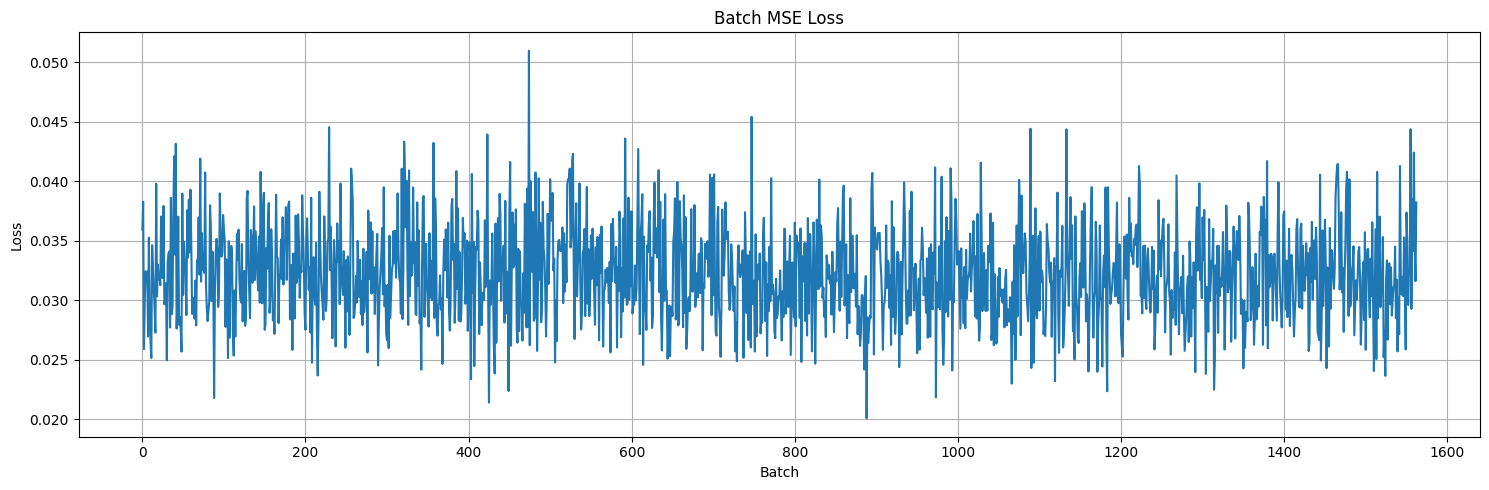

Final Batch MSE Loss: 0.04
Final Average MSE Loss: 0.03


In [20]:
# Plot training results
plt.figure(figsize=(15, 5))
plt.plot(batch_mse_losses)
plt.title('Batch MSE Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Batch MSE Loss: {batch_mse_losses[-1]:.2f}")
print(f"Final Average MSE Loss: {avg_mse_losses[-1]:.2f}")

In [21]:
def eval_on_mnist(model, loader, name="model"):
    print(model.eval())
    correct, total = 0, 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader, 1):
            x, y = x.to(device), y.to(device)

            # If y is one-hot, convert it to integer labels
            if y.ndim > 1:
                y = y.argmax(dim=1)

            logits = model(x)[:, :10]
            pred = logits.argmax(1)

            correct += (pred == y).sum().item()
            total += x.size(0)

            # Optional: print batch-wise accuracy every 50 batches
            if batch_idx % 50 == 0:
                batch_acc = (pred == y).float().mean().item()
                print(f"[{name}] Batch {batch_idx}: batch acc = {batch_acc:.4f}, cumulative acc = {correct/total:.4f}")

    final_acc = correct / total
    print(f"\n[{name}] MNIST final accuracy = {final_acc * 100:.2f}%")

eval_on_mnist(student_model, test_loader, name="Student")

TeacherNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

[Student] MNIST final accuracy = 99.93%


In [22]:
# New Student Neural Network Model
class NewStudentNet(nn.Module):
    def __init__(self, input_size=28*28, hidden1=256, hidden2=256, output_size=13):
        super(NewStudentNet, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_size)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Flatten the input (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(x.size(0), -1)
        
        # First hidden layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Second hidden layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x

# Create the teacher model
new_student_model = NewStudentNet()
print("Teacher Model Architecture:")
print(new_student_model)

# Count parameters
total_params = sum(p.numel() for p in new_student_model.parameters())
trainable_params = sum(p.numel() for p in new_student_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test the model with a sample input
sample_input = torch.randn(1, 1, 28, 28)
with torch.no_grad():
    sample_output = new_student_model(sample_input)
    print(f"\nSample input shape: {sample_input.shape}")
    print(f"Sample output shape: {sample_output.shape}")
    print(f"Sample output: {sample_output}")

Teacher Model Architecture:
NewStudentNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 270,093
Trainable parameters: 270,093

Sample input shape: torch.Size([1, 1, 28, 28])
Sample output shape: torch.Size([1, 13])
Sample output: tensor([[-0.1407,  0.0643, -0.0654,  0.0056, -0.0515,  0.0275, -0.0800,  0.0965,
         -0.2026, -0.0545,  0.0826,  0.1421,  0.1003]])


In [23]:
# Wrap noise dataset in a DataLoader with batch_size=64
noise_loader = torch.utils.data.DataLoader(noise_dataset_simple, batch_size=64, shuffle=True)

opt = torch.optim.Adam(student_model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

# Track epoch-wise average losses
avg_mse_losses = []

for epoch in range(1, 6):
    print(f"Epoch {epoch}")
    print("=" * 80)
    new_student_model.train()
    total_loss, n_batches = 0.0, 0
    batch_mse_losses = []

    for batch_idx, x in enumerate(noise_loader, 1):
        x = x.to(device)
        with torch.no_grad():
            t_logits_extra = teacher_model(x)[:, 10:]

        s_logits_extra = student_model(x)[:, 10:]    
        loss = mse_loss(s_logits_extra, t_logits_extra)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()
        n_batches += 1
        batch_mse_losses.append(loss.item())

        if batch_idx % 50 == 0:
            print(f"Epoch {epoch} Batch {batch_idx}: batch MSE loss = {loss.item():.4f}")

    avg_loss = total_loss / n_batches
    avg_mse_losses.append(avg_loss)
    print(f"Epoch {epoch} completed. Average MSE loss = {avg_loss:.4f}\n")

Epoch 1
Epoch 1 Batch 50: batch MSE loss = 0.0224
Epoch 1 Batch 100: batch MSE loss = 0.0191
Epoch 1 Batch 150: batch MSE loss = 0.0335
Epoch 1 Batch 200: batch MSE loss = 0.0232
Epoch 1 Batch 250: batch MSE loss = 0.0257
Epoch 1 Batch 300: batch MSE loss = 0.0244
Epoch 1 Batch 350: batch MSE loss = 0.0250
Epoch 1 Batch 400: batch MSE loss = 0.0192
Epoch 1 Batch 450: batch MSE loss = 0.0264
Epoch 1 Batch 500: batch MSE loss = 0.0231
Epoch 1 Batch 550: batch MSE loss = 0.0314
Epoch 1 Batch 600: batch MSE loss = 0.0200
Epoch 1 Batch 650: batch MSE loss = 0.0278
Epoch 1 Batch 700: batch MSE loss = 0.0228
Epoch 1 Batch 750: batch MSE loss = 0.0238
Epoch 1 Batch 800: batch MSE loss = 0.0226
Epoch 1 Batch 850: batch MSE loss = 0.0270
Epoch 1 Batch 900: batch MSE loss = 0.0215
Epoch 1 Batch 950: batch MSE loss = 0.0203
Epoch 1 Batch 1000: batch MSE loss = 0.0280
Epoch 1 Batch 1050: batch MSE loss = 0.0224
Epoch 1 Batch 1100: batch MSE loss = 0.0244
Epoch 1 Batch 1150: batch MSE loss = 0.0252


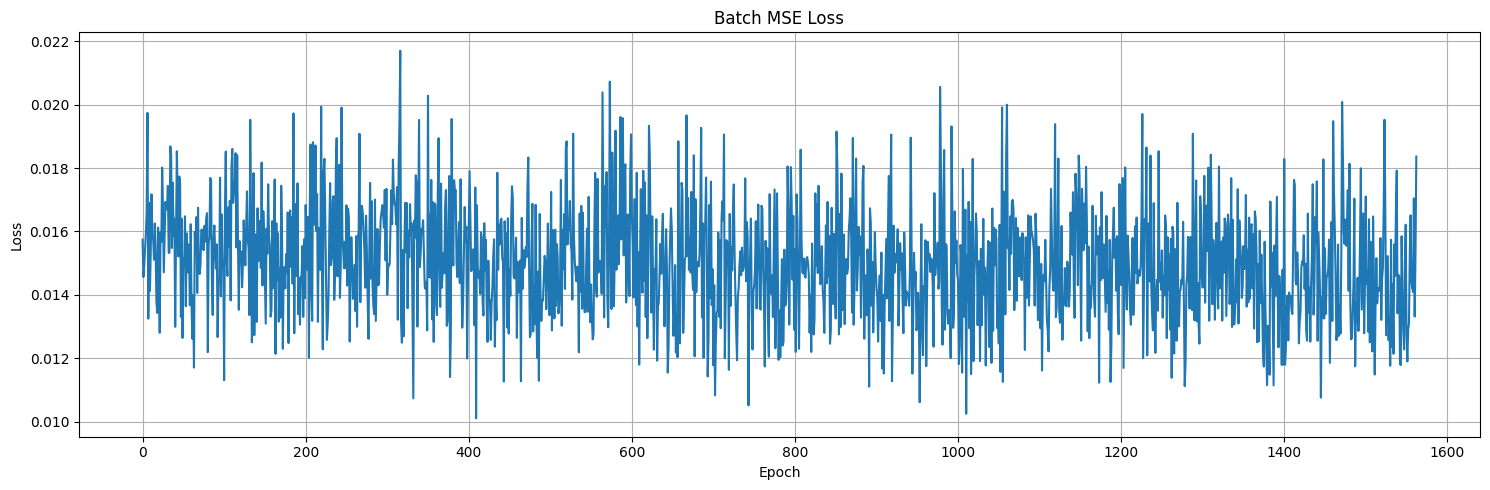

Final Batch MSE Loss: 0.02
Final Average MSE Loss: 0.02


In [24]:
# Plot training results
plt.figure(figsize=(15, 5))
plt.plot(batch_mse_losses)
plt.title('Batch MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Batch MSE Loss: {batch_mse_losses[-1]:.2f}")
print(f"Final Average MSE Loss: {avg_mse_losses[-1]:.2f}")

In [26]:
def eval_on_mnist(model, loader, name="model"):
    print(model.eval())
    correct, total = 0, 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader, 1):
            x, y = x.to(device), y.to(device)

            # If y is one-hot, convert it to integer labels
            if y.ndim > 1:
                y = y.argmax(dim=1)

            logits = model(x)[:, :10]
            pred = logits.argmax(1)

            correct += (pred == y).sum().item()
            total += x.size(0)

            # Optional: print batch-wise accuracy every 50 batches
            if batch_idx % 50 == 0:
                batch_acc = (pred == y).float().mean().item()
                print(f"[{name}] Batch {batch_idx}: batch acc = {batch_acc:.4f}, cumulative acc = {correct/total:.4f}")

    final_acc = correct / total
    print(f"\n[{name}] MNIST final accuracy = {final_acc * 100:.2f}%")

eval_on_mnist(new_student_model, test_loader, name="New Student")

NewStudentNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

[New Student] MNIST final accuracy = 13.60%
